<a href="https://colab.research.google.com/github/MikeSalnikov/ML_for_business/blob/main/HW2_webinar2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](payments1.png "Payments2")

#### 2. по психотипам

![ab_split](psycho.png "Psycho")

#### 3. по платежам

![ab_split](payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](uplift.png "Uplift")

#### 5. по интересам

![ab_split](interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](tm1.png "TM1")

### ПЕРЕРЫВ ДО 21:10 (МСК)

### Переходим к практике

In [4]:
import pandas as pd

Наши новости

In [5]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [7]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [11]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [23]:
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 42.8 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=f29dd1ca3963fc007ec94b2f9750aa938225eb82b42e6d991009d99ae8d5bb7c
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [38]:
from nltk.tokenize import word_tokenize

In [52]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [55]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [56]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [57]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [58]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [59]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-58-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 27.7 s, sys: 1.24 s, total: 28.9 s
Wall time: 29 s


In [61]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 1s, sys: 1.07 s, total: 4min 2s
Wall time: 4min 3s


А теперь в 3 строчки обучим нашу модель

In [62]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [63]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [64]:
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [65]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [66]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(5, 0.2653677),
 (10, 0.031108296),
 (15, 0.054391325),
 (16, 0.5556998),
 (18, 0.07392065)]

In [67]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: учёный сша смерть нефть эксперт клетка баррель
topic_1: земля космический тело космос задержать активность рейс
topic_2: область nn станция регион век технология день
topic_3: исследователь ракета научный цена новый учёный запуск
topic_4: писать товар украина франция привести террорист политический
topic_5: рак журнал дыра nn геном первый лёд
topic_6: самолёт корабль погибнуть экипаж обнаружить полёт остров
topic_7: ссср советский авария современный ленин спустя разместить
topic_8: рост млн банк экономика вырасти доход составить
topic_9: спутник пострадать взрыв произойти дом здание восток
topic_10: млрд руб луна объём риск бюджет поверхность
topic_11: женщина автомобиль мужчина городской известный академия школа
topic_12: рф россия действие территория армия данные следствие
topic_13: рубль россия статья фонд эксперт район газета
topic_14: гражданин ребёнок украина снижение украинский пенсия россия
topic_15: всё очень день жизнь большой жить первый
topic_16: продукция место хо

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [68]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [69]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.000000,0.0,0.0,0.092356,0.000000,0.0,0.093964,...,0.00000,0.013774,0.0,0.000000,0.0,0.000000,0.0,0.0,0.045482,0.000000
1,4896,0.0,0.075996,0.000000,0.0,0.0,0.258248,0.000000,0.0,0.000000,...,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,4897,0.0,0.000000,0.000000,0.0,0.0,0.268055,0.000000,0.0,0.000000,...,0.00000,0.549023,0.0,0.072318,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,4898,0.0,0.000000,0.000000,0.0,0.0,0.141437,0.000000,0.0,0.000000,...,0.48274,0.067190,0.0,0.000000,0.0,0.173571,0.0,0.0,0.000000,0.000000
4,4899,0.0,0.000000,0.209862,0.0,0.0,0.000000,0.337044,0.0,0.000000,...,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.118527


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [70]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [71]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [72]:
doc_dict[293622]

array([0.0522808 , 0.        , 0.02971112, 0.        , 0.        ,
       0.02150732, 0.        , 0.        , 0.02604514, 0.        ,
       0.        , 0.34981862, 0.        , 0.06951536, 0.        ,
       0.04938666, 0.        , 0.        , 0.        , 0.03189906,
       0.        , 0.20328029, 0.        , 0.        , 0.16010399])

In [73]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [74]:
get_user_embedding(user_articles_list)

array([0.06430128, 0.01679418, 0.        , 0.03795856, 0.01473478,
       0.00898361, 0.01342315, 0.00517349, 0.00348472, 0.00693123,
       0.01821326, 0.03415971, 0.0858766 , 0.0342363 , 0.01208609,
       0.03126097, 0.        , 0.00206244, 0.19016462, 0.        ,
       0.        , 0.02471491, 0.04456952, 0.05674895, 0.28202016])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [75]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [76]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [77]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.008713,0.017989,0.087570,0.005268,0.067927,0.028094,0.001928,0.022331,0.070151,...,0.025042,0.000000,0.004981,0.032239,0.104383,0.000000,0.056590,0.000000,0.075119,0.097103
1,u108690,0.071275,0.008442,0.022885,0.009076,0.048675,0.000000,0.000000,0.015345,0.015216,...,0.105160,0.003407,0.001873,0.097149,0.005913,0.025055,0.063465,0.009282,0.028752,0.156318
2,u108339,0.035212,0.018602,0.055811,0.000000,0.019310,0.000000,0.027997,0.015274,0.004684,...,0.040958,0.000000,0.020076,0.132417,0.000000,0.000000,0.051620,0.020423,0.022143,0.125072


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [78]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [79]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.008713,0.017989,0.087570,0.005268,0.067927,0.028094,0.001928,0.022331,0.070151,...,0.000000,0.004981,0.032239,0.104383,0.000000,0.056590,0.000000,0.075119,0.097103,0
1,u108690,0.071275,0.008442,0.022885,0.009076,0.048675,0.000000,0.000000,0.015345,0.015216,...,0.003407,0.001873,0.097149,0.005913,0.025055,0.063465,0.009282,0.028752,0.156318,1
2,u108339,0.035212,0.018602,0.055811,0.000000,0.019310,0.000000,0.027997,0.015274,0.004684,...,0.000000,0.020076,0.132417,0.000000,0.000000,0.051620,0.020423,0.022143,0.125072,1


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [81]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [82]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [83]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06038713, 0.02039512, 0.51311569, 0.38077075, 0.05619384,
       0.11268667, 0.12895334, 0.06329882, 0.08738163, 0.02989875])

In [84]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [85]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.286050, F-Score=0.723, Precision=0.707, Recall=0.739


In [86]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1680   75]
 [  65  180]]


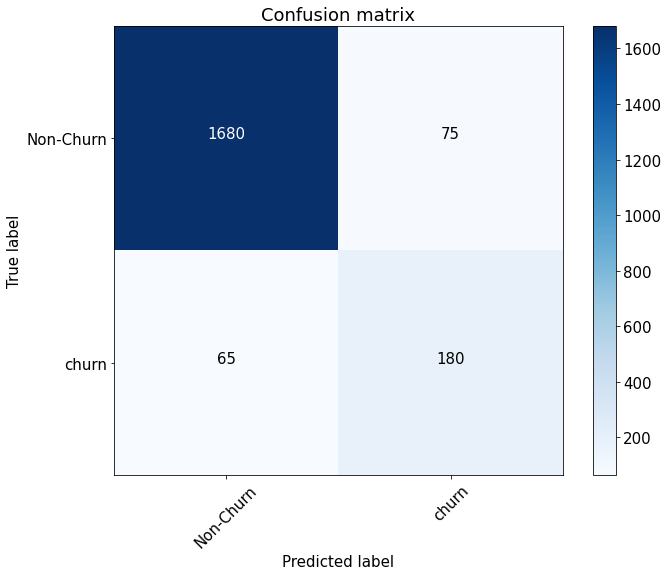

In [87]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [88]:
roc_auc_score(y_test, preds)

0.9631629745915461

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 4 разных методов получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

In [90]:
user_articles_list_median = users['articles'].iloc[33]

def get_user_embedding_median(user_articles_list_median):
    user_articles_list = eval(user_articles_list_median)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0) # медиана
    return user_vector

In [92]:
get_user_embedding_median(user_articles_list_median)

array([0.0179338 , 0.        , 0.        , 0.        , 0.00658744,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01377794, 0.        ,
       0.        , 0.        , 0.        , 0.14747132, 0.        ,
       0.        , 0.        , 0.00503753, 0.02295703, 0.20739403])

In [93]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.014856,0.0,0.038097,0.010566,0.0,0.000000,0.013023,...,0.021473,0.0,0.00000,0.000000,0.0432,0.0,0.017316,0.000000,0.000000,0.071602
1,u108690,0.0,0.000000,0.005134,0.0,0.030287,0.000000,0.0,0.006259,0.000000,...,0.108715,0.0,0.00000,0.037294,0.0000,0.0,0.054665,0.000000,0.022658,0.154222
2,u108339,0.0,0.008173,0.027577,0.0,0.009200,0.000000,0.0,0.016600,0.000000,...,0.023029,0.0,0.01511,0.038884,0.0000,0.0,0.042028,0.014139,0.016346,0.131026


In [94]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [95]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.014856,0.0,0.038097,0.010566,0.0,0.000000,0.013023,...,0.0,0.00000,0.000000,0.0432,0.0,0.017316,0.000000,0.000000,0.071602,0
1,u108690,0.0,0.000000,0.005134,0.0,0.030287,0.000000,0.0,0.006259,0.000000,...,0.0,0.00000,0.037294,0.0000,0.0,0.054665,0.000000,0.022658,0.154222,1
2,u108339,0.0,0.008173,0.027577,0.0,0.009200,0.000000,0.0,0.016600,0.000000,...,0.0,0.01511,0.038884,0.0000,0.0,0.042028,0.014139,0.016346,0.131026,1


In [96]:
#разделим данные на train/test
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [97]:
logreg_median = LogisticRegression()
#обучим 
logreg_median.fit(X_median_train, y_median_train)

LogisticRegression()

In [98]:
#наши прогнозы для тестовой выборки
preds_median = logreg_median.predict_proba(X_median_test)[:, 1]
preds_median[:10]

array([0.09881296, 0.02984453, 0.68428554, 0.27739868, 0.04333574,
       0.05881052, 0.08733357, 0.07329593, 0.08019079, 0.07389222])

In [99]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_median_test, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

Best Threshold=0.280880, F-Score=0.787, Precision=0.760, Recall=0.816


Confusion matrix, without normalization
[[1692   63]
 [  46  199]]


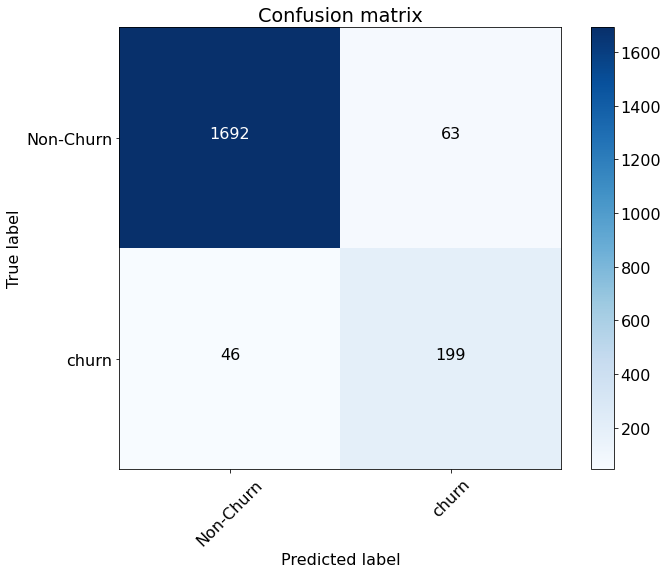

In [102]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 16}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_median_test, preds_median>thresholds_median[ix_median])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [103]:
# print(f'Метрика roc auc для median: {roc_auc_median}')
print(f'Метрика precision для median: {precision_median[ix_median]}')
print(f'Метрика recall для median: {recall_median[ix_median]}')
print(f'Метрика f_score для median: {fscore_median[ix_median]}')

Метрика precision для median: 0.7604562737642585
Метрика recall для median: 0.8163265306122449
Метрика f_score для median: 0.7874015748031497


Повторить п.2, но используя уже не медиану, а max

In [104]:
user_articles_list_max = users['articles'].iloc[33]

def get_user_embedding_max(user_articles_list_max):
    user_articles_list = eval(user_articles_list_max)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0) # максимальное
    return user_vector

In [105]:
get_user_embedding_max(user_articles_list_max)

array([0.29048949, 0.10076506, 0.        , 0.22775137, 0.03819979,
       0.03239211, 0.08053888, 0.03104094, 0.02090831, 0.04158739,
       0.09824198, 0.17787926, 0.36189499, 0.12119191, 0.06226515,
       0.1875658 , 0.        , 0.01237465, 0.52093488, 0.        ,
       0.        , 0.10187013, 0.15737401, 0.17280711, 0.72433746])

In [106]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.052281,0.074230,0.345493,0.031605,0.262173,0.125926,0.011571,0.071837,0.356143,...,0.057920,0.000000,0.029889,0.193431,0.481427,0.000000,0.203280,0.000000,0.450716,0.250745
1,u108690,0.376839,0.033594,0.091244,0.039840,0.136900,0.000000,0.000000,0.055196,0.051620,...,0.291935,0.010295,0.011236,0.312809,0.017775,0.137986,0.144221,0.032963,0.067867,0.251821
2,u108339,0.117652,0.070134,0.216571,0.000000,0.053954,0.000000,0.111251,0.033948,0.015124,...,0.133630,0.000000,0.055118,0.376167,0.000000,0.000000,0.142554,0.050540,0.059094,0.236132


In [107]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.052281,0.074230,0.345493,0.031605,0.262173,0.125926,0.011571,0.071837,0.356143,...,0.000000,0.029889,0.193431,0.481427,0.000000,0.203280,0.000000,0.450716,0.250745,0
1,u108690,0.376839,0.033594,0.091244,0.039840,0.136900,0.000000,0.000000,0.055196,0.051620,...,0.010295,0.011236,0.312809,0.017775,0.137986,0.144221,0.032963,0.067867,0.251821,1
2,u108339,0.117652,0.070134,0.216571,0.000000,0.053954,0.000000,0.111251,0.033948,0.015124,...,0.000000,0.055118,0.376167,0.000000,0.000000,0.142554,0.050540,0.059094,0.236132,1


In [108]:
#разделим данные на train/test
X_max_train, X_max_test, y_max_train, y_max_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [109]:
logreg_max = LogisticRegression()
#обучим 
logreg_max.fit(X_max_train, y_max_train)

LogisticRegression()

In [110]:
#наши прогнозы для тестовой выборки
preds_max = logreg_max.predict_proba(X_max_test)[:, 1]
preds_max[:10]

array([5.12865674e-02, 5.60659230e-04, 8.27577251e-01, 1.49871598e-01,
       5.01576046e-02, 5.64817053e-03, 1.36095607e-01, 5.57983877e-03,
       1.42768702e-01, 1.90597726e-02])

In [111]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_max_test, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Best Threshold=0.400007, F-Score=0.796, Precision=0.804, Recall=0.788


Confusion matrix, without normalization
[[1708   47]
 [  53  192]]


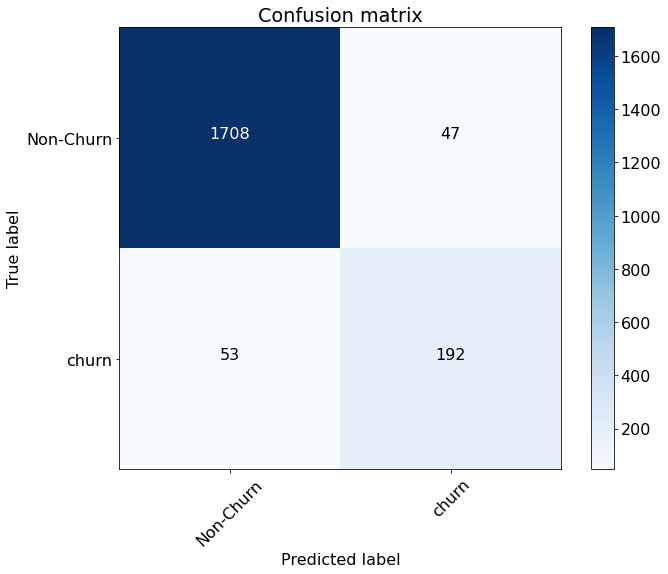

In [113]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 16}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_max_test, preds_max>thresholds_max[ix_max])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [114]:
# print(f'Метрика roc auc для max: {roc_auc_max}')
print(f'Метрика precision для median: {precision_max[ix_max]}')
print(f'Метрика recall для median: {recall_max[ix_max]}')
print(f'Метрика f_score для median: {fscore_max[ix_max]}')

Метрика precision для median: 0.8041666666666667
Метрика recall для median: 0.7877551020408163
Метрика f_score для median: 0.7958762886597938


Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max по метрикам precision, recall, f_score

In [115]:
results = {'precision': [precision[ix], precision_median[ix_median], precision_max[ix_max]], 
           'recall': [recall[ix], recall_median[ix_median], recall_max[ix_max]], 
           'f_score': [fscore[ix], fscore_median[ix_median], fscore_max[ix_max]]} 
 
df_results = pd.DataFrame(results, index =['mean', 'median', 'max']) 
df_results

,precision,recall,f_score
mean,0.707031,0.738776,0.722555
median,0.760456,0.816327,0.787402
max,0.804167,0.787755,0.795876


Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Исходя из полученных данных, можно заметить улучшение (рост) метрик при использовании соответственно mean, median, max. Вариант с max - лучший в качестве метода получения эмбеддингов пользователей. Он выглядит наиболее сбалансированным по параметрам precision, recall, и f_score.

Представим матрицу векторов статей пользователя. Столбцы - это статьи, строки - темы. Если у нас имеется несколько статей, с большой вероятностью отнесенных к определенной теме, а в остальных статьях будут нули на этой теме, то вместо того, чтобы четко соотнести интерес пользователя к этой теме, мы наоборот занижаем это значение взятием среднего. Поэтому результат получается самым худшим.

При взятии медианы мы часто зануляем значение "интереса" пользователя к тематике, если статей этой тематики недостаточно много. Но при этом хорошо улавливаем основные тематики интересов пользователя.

Как показал эксперимент, лучшим методом оказалось взятие максимума. При этом мы не уменьшаем и не зануляем средние и мелкие блоки тем и так же хорошо улавливаем крупные. То есть при таком методе подсчета можно сказать, что модель хорошо улавливает и основные интересы пользователя, но также отмечает интерес к малочисленным, но хорошо кластеризованным статьям.